In [3]:
#Imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from matplotlib import gridspec
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error

import imageio
from tqdm.auto import tqdm
sys.path.insert(1, r"..\src")
import utils

In [13]:
test_images = np.load(r"..\data\01_data_simulation\test_data\test_images.npy")
test_histograms = np.load(r"..\data\01_data_simulation\test_data\test_histograms.npy")
predictions = np.zeros((10,10,100,80,80))
for i in range(10):
    predictions[:,i,:,:,:] = np.load(r"..\data\01_data_simulation\predictions{}.npy".format(i))  # We include 1 model initialisation per max scattering event number,
                                                                                      # so to be able to access all 10 initialisation per max scattering event number,
                                                                                      # we'll load in the predictions directly. 
time_series = np.load(r"..\data\01_data_simulation\time_series.npy")
background_mask = np.load(r"..\data\01_data_simulation\test_data\background_mask.npy")

# Define parameters of the simulation
d_max = 6.878107563940884 #from the simulation, this is the maximum distance in the room, from the camera: 6.88 m
test_images = test_images*d_max

In [14]:
# Reshape to needed size
test_histograms = np.reshape(test_histograms, (-1, test_histograms.shape[1], test_histograms.shape[2]))
test_images = np.reshape(test_images, (test_images.shape[0], test_images.shape[1], test_images.shape[2], test_images.shape[3]))

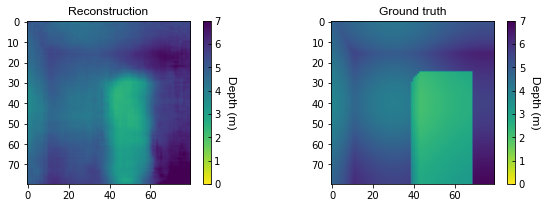

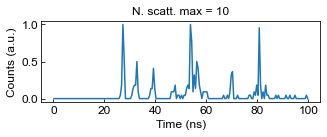

In [15]:
# Plot examples for visualisation
# M1b, M1c - set to test set, n = 4, co = 55
n = 9
co = 55 

plt.figure(figsize=(10,3),dpi=72)
plt.subplot(122)
plt.title('Ground truth',fontsize=12,fontname='Arial')
plt.imshow(test_images[n,co,:,:],cmap='viridis_r',vmin=0,vmax=np.ceil(d_max))
cbar=plt.colorbar()
cbar.set_label('Depth (m)',rotation=270,labelpad=15,fontsize=12,fontname='Arial')
cbar.ax.tick_params(direction='in')
plt.subplot(121)
plt.title('Reconstruction',fontsize=12,fontname='Arial')
plt.imshow(predictions[n,0,co,:,:],cmap='viridis_r',vmin=0,vmax=np.ceil(d_max))
cbar=plt.colorbar()
cbar.set_label('Depth (m)',rotation=270,labelpad=15,fontsize=12,fontname='Arial')
cbar.ax.tick_params(direction='in')
plt.show()
fig=plt.figure(figsize=(5,1.5),dpi=72)
plt.title('N. scatt. max = {}'.format(n+1),fontsize=12,fontname='Arial')
plt.tick_params(direction='in')
plt.plot(time_series,test_histograms[n, co])
plt.xticks(fontsize=12,fontname='Arial')
plt.yticks(fontsize=12,fontname='Arial')
plt.xlabel('Time (ns)',fontsize=12,fontname='Arial')
plt.ylabel('Counts (a.u.)',fontsize=12,fontname='Arial')
plt.show()

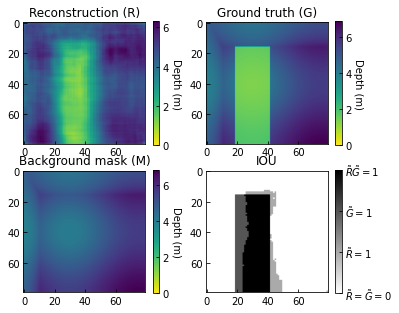

In [16]:
FMSE,IOU = utils.fmse_iou(predictions[2,0,33],test_images[2,33],mask=background_mask,k=0.5,show=True)

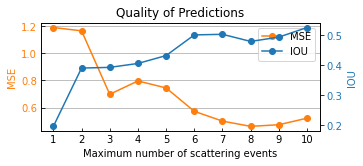

In [17]:
# Obtain performance metrics
mse_list=np.zeros((10,10,100))
ssim_list=np.zeros((10,10,100))
fmse_list =  np.zeros((10,10,100))
iou_list =  np.zeros((10,10,100))

mean_mse = np.zeros(10)
mean_ssim = np.zeros(10)
mean_fmse = np.zeros(10)
mean_iou = np.zeros(10)
    
for n in range(10): # loop over the number of scattering events   
    for m in range(10): # loop over the number of examples   
        for i in range(100): # loop over the test examples in each block of scattering events
            mse_list[n,m,i]=mean_squared_error(test_images[n,i,],predictions[n,m,i])
            ssim_list[n,m,i]=structural_similarity(test_images[n,i],predictions[n,m,i],max_val=1)
            fMSE, IOU = utils.fmse_iou(predictions[n,m,i],test_images[n,i],background_mask,0.5)
            fmse_list[n,m,i]= fMSE
            iou_list[n,m,i]=IOU
            
    mean_mse[n] = np.mean(mse_list[n,:])
    mean_ssim[n] = np.mean(ssim_list[n,:])
    mean_fmse[n] = np.mean(fmse_list[n,:])
    mean_iou[n] = np.mean(iou_list[n,:])

fig = plt.figure(figsize=(5,2))
ax1 = fig.add_subplot(111)
ax1.tick_params(direction='in')
plt.title('Quality of Predictions')
plt.xticks(range(1,11))
plt.xlabel('Maximum number of scattering events')
plt.grid(b=True, axis='y')

#MSE and foreground MSE (FMSE)
color = 'tab:orange'
ax1.set_ylabel('MSE',color=color) 
mse = ax1.plot(range(1,11),mean_mse, color=color, label='MSE',marker='o')
#f_mse = ax1.plot(range(1,11),mean_fmse,color='yellow',label='Foreground MSE')
ax1.tick_params(axis='y', labelcolor=color)

##IOU and SSIM
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('IOU', color=color) 
iou = ax2.plot(range(1,11),mean_iou, color=color, label='IOU',marker='o')
#ssim= ax2.plot(range(1,11),mean_ssim, color='black', label='SSIM')
ax2.tick_params(axis='y', labelcolor=color)

lns = mse+iou#+f_mse+ssim
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()